---
title: Near deduplication -- test on MS AR
collapse: 3
parent: HuggingFace
---

In [1]:
#' include=output
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Setup

In [5]:
import re
import pandas as pd
import os
import numpy as np
from time import time
from pathlib import Path
from datasets import load_dataset, concatenate_datasets, Dataset
#from alpha_tools.bud import io
#from alpha_tools.thoth.pipelines import PandasPipeline, get_prefix_from_title

# 0. Code

In [2]:
"""
From: https://github.com/bigcode-project/bigcode-dataset/tree/main/near_deduplication
"""

from __future__ import annotations

import gc
import hashlib
import logging
import multiprocessing as mp
import os
import random
import re
import struct
import time
import warnings
from collections import defaultdict
from itertools import tee
from pathlib import Path
from typing import Any
from typing import Dict
from typing import Iterable
from typing import List
from typing import Tuple

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import datasets
    import numpy as np
    import typer
    from datasets import load_dataset
    from scipy.integrate import quad as integrate
    from tqdm import tqdm


SEED = 42
NON_ALPHA = re.compile("[^A-Za-z_0-9]")
RNG = np.random.RandomState(SEED)
MAX_HASH = np.uint64((1 << 32) - 1)
MERSENNE_PRIME = np.uint64((1 << 61) - 1)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
datasets.logging.set_verbosity_error()


def ngrams(sequence: List[str], n: int, min_ngram_size: int) -> Iterable:
    """
    Directly taken from nltk package to avoid dependency.
    Parameters
    ----------
    sequence : list
        The sequence of items to be n-grammed.
    n : int
        The order of the n-grams to be extracted.
    min_ngram_size : int
        The minimum size of n-grams.
    Returns
    -------
    Iterable
        The n-grams generated from the sequence.
    """
    if len(sequence) < min_ngram_size:
        return []
    iterables = tee(sequence, n)
    for i, sub_iterable in enumerate(iterables):
        for _ in range(i):
            next(sub_iterable, None)
    return zip(*iterables)


def sha1_hash32(data):
    """
    Directly taken from datasketch package to avoid dependency.
    Parameters
    ----------
    data : bytes
    Returns
    -------
    int
    """
    return struct.unpack("<I", hashlib.sha1(data).digest()[:4])[0]


def embed_func(
    content: str,
    idx: int,
    *,
    num_perm: int,
    ngram_size: int,
    hashranges: List[Tuple[int, int]],
    permutations: np.ndarray,
    min_ngram_size: int = 5,
) -> Dict[str, Any]:
    """
    Combined with some datasketch code to better parallelize computation.
    Parameters
    ----------
    content : str
        The content to be embedded.
    idx : int
        The index of the content.
    num_perm : int
        The number of permutations.
    ngram_size : int
        The size of n-grams.
    hashranges : List[Tuple[int, int]]
        The ranges of hash values.
    permutations : np.ndarray
        The permutations for the minhash.
    min_ngram_size : int
        The minimum size of n-grams.
    Returns
    -------
    Dict[str, Any]
        The hash values in each range and the index.
    """
    hashvalues = np.ones(num_perm, dtype=np.uint64) * MAX_HASH
    tokens = {" ".join(t) for t in ngrams(NON_ALPHA.split(content), ngram_size, min_ngram_size)}
    hv = np.array([sha1_hash32(token.encode("utf-8")) for token in tokens], dtype=np.uint64)  # noqa: E501
    a, b = permutations
    phv = np.bitwise_and(((hv * np.tile(a, (len(hv), 1)).T).T + b) % MERSENNE_PRIME, MAX_HASH)  # noqa: E501
    hashvalues = np.vstack([phv, hashvalues]).min(axis=0)
    Hs = [bytes(hashvalues[start:end].byteswap().data) for start, end in hashranges]
    return {"__signatures__": Hs, "__id__": idx}


def optimal_param(
    threshold: float,
    num_perm: int,
    false_positive_weight: float = 0.5,
    false_negative_weight: float = 0.5,
):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative, taken from datasketch.
    Parameters
    ----------
    threshold : float
        The threshold for similarity.
    num_perm : int
        The number of permutations.
    false_positive_weight : float
        The weight of false positive.
    false_negative_weight : float
        The weight of false negative.
    Returns
    -------
    Tuple[int, int]
        The optimal `b` and `r` parameters.
        The number of bands, and the number of rows per band respectively.
    """

    def false_positive_probability(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def proba(s):
            return 1 - (1 - s ** float(r)) ** float(b)

        a, _ = integrate(proba, 0.0, threshold)
        return a

    def false_negative_probability(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def proba(s):
            return 1 - (1 - (1 - s ** float(r)) ** float(b))

        a, _ = integrate(proba, threshold, 1.0)
        return a

    min_error = float("inf")
    opt = (0, 0)
    for b in range(1, num_perm + 1):
        max_r = int(num_perm / b)
        for r in range(1, max_r + 1):
            fp = false_positive_probability(threshold, b, r)
            fn = false_negative_probability(threshold, b, r)
            error = fp * false_positive_weight + fn * false_negative_weight
            if error < min_error:
                min_error = error
                opt = (b, r)
    return opt


class UnionFind:
    def __init__(self):
        self.parent: Dict[int, int] = {}

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        px = self.find(x)
        py = self.find(y)
        self.parent[px] = self.parent[py] = min(px, py)

/home/yzhong/conda/envs/env_test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Loading data

In [49]:
text = pd.read_parquet('/mnt/research-live/user/yzhong/All_stock_news.parquet')

In [50]:
text

,suid,last_update,eqt_code,date,topics,headline
0,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...
1,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_R_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...
2,O08ZLH6KLVR4,2016-01-01 00:20:05.237,MU_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
3,O08ZLH6KLVR4,2016-01-01 00:20:05.237,CNX_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
4,O08ZLH6KLVR4,2016-01-01 00:20:05.237,WFR_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
...,...,...,...,...,...,...
29331835,R504BHT1UM0W,2021-12-31 23:05:11.604,KEY_UN,2021-12-31,BIZNEWS CNG MSCIWORLD NORTHAM GLOBALMACR EQTY ...,Trump Holdover McWilliams to Step Down as FDIC...
29331836,R505TGGQOFSW,2021-12-31 23:12:52.308,603712_CH,2021-12-31,BIZNEWS BUSINESS MISC MISCCOS PROXY CMP PREPRO...,Florida SBA Backs Tianjin 712 on 2 of 2 Propos...
29331837,R506M2GF4NPC,2021-12-31 23:30:02.315,FNM_UN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...
29331838,R506M2GF4NPC,2021-12-31 23:30:02.315,BAM_UN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...


In [52]:
text_=text[['suid','last_update','headline']]

In [53]:
print(f'Number of documents before cleaning: {len(text_)}')
print(text_.shape)
text_.head()

Number of documents before cleaning: 29331840
(29331840, 3)


,suid,last_update,headline
0,O08R5DSYF01S,2016-01-01 00:01:00.202,Europe Stocks: From Euphoric to Just Enviable ...
1,O08R5DSYF01S,2016-01-01 00:01:00.202,Europe Stocks: From Euphoric to Just Enviable ...
2,O08ZLH6KLVR4,2016-01-01 00:20:05.237,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
3,O08ZLH6KLVR4,2016-01-01 00:20:05.237,Einhorn’s Greenlight Fund Ends Second-Worst Ye...
4,O08ZLH6KLVR4,2016-01-01 00:20:05.237,Einhorn’s Greenlight Fund Ends Second-Worst Ye...


In [88]:
%%time
pp = PandasPipeline()
text_ = pp.compose(context, config=cfg, args_as_dict={'other': text})

CPU times: user 3min 30s, sys: 5.49 s, total: 3min 35s
Wall time: 3min 36s


In [90]:
print(f'Number of documents after cleaning: {len(text_)}')
print(f'Discarded documents (%): {100*(1 - len(text_) / len(text)):.2f}')

Number of documents after cleaning: 466924
Discarded documents (%): 16.86


# 3. Deduplication

In [54]:
ds = Dataset.from_pandas(text_)

In [19]:
import time
start_time = time.time()

In [55]:

column: str = "headline"
ngram_size: int = 5
num_perm: int = 256
threshold: float = 0.7
min_ngram_size: int = 5

global uf

uf = UnionFind()

logging.basicConfig(level=logging.INFO)

time_measures = {}
start_time = time.time()

B, R = optimal_param(threshold, num_perm)
HASH_RANGES = [(i * R, (i + 1) * R) for i in range(B)]
HASH_TABLES = [defaultdict(set) for _ in range(B)]


DATA_SIZE = len(ds)
PERMUTATIONS = np.array(
    [
        (
            RNG.randint(1, MERSENNE_PRIME, dtype=np.uint64),
            RNG.randint(0, MERSENNE_PRIME, dtype=np.uint64),
        )
        for _ in range(num_perm)
    ],
    dtype=np.uint64,
).T

time_measures["minhash"] = time.time()
embedded = ds.map(
    function=embed_func,
    fn_kwargs={
        "num_perm": num_perm,
        "hashranges": HASH_RANGES,
        "ngram_size": ngram_size,
        "permutations": PERMUTATIONS,
        "min_ngram_size": min_ngram_size,
    },
    input_columns=[column],
    remove_columns=ds.column_names,
    num_proc=os.cpu_count(),
    with_indices=True,
    desc="Fingerprinting...",
)
time_measures["minhash"] = time.time() - time_measures["minhash"]

time_measures["clustering"] = time.time()
batch_size: int = 10000
for i in tqdm(
    range(0, len(embedded), batch_size), dynamic_ncols=True, desc="Iterating MinHashes..."  # noqa: E501
):
    batch = embedded[i : i + batch_size]
    for key, Hs in zip(batch["__id__"], batch["__signatures__"]):
        for H, hashtable in zip(Hs, HASH_TABLES):
            hashtable[H].add(key)
for table in tqdm(HASH_TABLES, dynamic_ncols=True, desc="Clustering..."):
    for cluster in table.values():
        if len(cluster) <= 1:
            continue
        idx = min(cluster)
        for x in cluster:
            uf.union(x, idx)
time_measures["clustering"] = time.time() - time_measures["clustering"]

time_measures["filtering"] = time.time()
gc.freeze()
gc.disable()
ds = ds.map(
    function=lambda _, idx: {"__cluster__": uf.find(idx)},
    with_indices=True,
    num_proc=os.cpu_count(),
    new_fingerprint=str(random.getrandbits(128)),
    desc="Finding clusters...",
)
gc.enable()
gc.collect()
# This is where the deduplication happens
# Since there is no easy groupby in datasets
# I will use this simple filter for now
final_data = ds.filter(
    function=lambda record, idx: record["__cluster__"] == idx,
    with_indices=True,
    num_proc=os.cpu_count()//4,
    desc="Filtering clusters...",
)
time_measures["filtering"] = time.time() - time_measures["filtering"]


FINAL_DATA_SIZE = len(final_data)
DUP_SIZE = DATA_SIZE - FINAL_DATA_SIZE
PAD = 32

for key, value in time_measures.items():
    logger.info(f"{key:<{PAD}}: {value:.2f} seconds")
logger.info(f"{'Data Number (before)':<{PAD}}: {DATA_SIZE}")
logger.info(
    f"{'Data Number (after)':<{PAD}}: {FINAL_DATA_SIZE} ({FINAL_DATA_SIZE / DATA_SIZE:.2%})"  # noqa: E501
)
logger.info(f"{'Duplicate Number':<{PAD}}: {DUP_SIZE} ({DUP_SIZE / DATA_SIZE:.2%})")  # noqa: E501
logger.info(f"{'Total Time':<{PAD}}: {time.time() - start_time:.2f} seconds")
#logger.info(f"{'Deduplicated Dataset':<{PAD}}: {output}")
logger.info("🤗 Happy Deduplicating 🤗")

#mp.set_start_method("fork", force=True)

Clustering...: 100%|██████████| 25/25 [14:20<00:00, 34.41s/it]
INFO:__main__:minhash                         : 729.23 seconds                                             
INFO:__main__:clustering                      : 2750.83 seconds
INFO:__main__:filtering                       : 572.97 seconds
INFO:__main__:Data Number (before)            : 29331840
INFO:__main__:Data Number (after)             : 9807404 (33.44%)
INFO:__main__:Duplicate Number                : 19524436 (66.56%)
INFO:__main__:Total Time                      : 4059.82 seconds
INFO:__main__:🤗 Happy Deduplicating 🤗


In [70]:
# Convert the dataset to a pandas dataframe
df = final_data.to_pandas()
# Save the dataframe to a Parquet file
df.to_parquet("/mnt/research-live/user/yzhong/deduplicate_all_stocks_pretrainUse.parquet", index=False)

In [73]:
merged.to_parquet("/mnt/research-live/user/yzhong/deduplicate_all_stocks_volumespikeUse.parquet", index=False)

In [71]:
merged = text.merge(df, on=['suid', 'last_update'], how='inner')
merged

,suid,last_update,eqt_code,date,topics,headline_x,headline_y,__cluster__
0,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...,Europe Stocks: From Euphoric to Just Enviable ...,0
1,O08R5DSYF01S,2016-01-01 00:01:00.202,DDBC_R_DC,2016-01-01,GBN ORIGINAL FIN REGIONFILT EUROPE CEN CECO PO...,Europe Stocks: From Euphoric to Just Enviable ...,Europe Stocks: From Euphoric to Just Enviable ...,0
2,O08ZLH6KLVR4,2016-01-01 00:20:05.237,MU_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,2
3,O08ZLH6KLVR4,2016-01-01 00:20:05.237,CNX_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,2
4,O08ZLH6KLVR4,2016-01-01 00:20:05.237,WFR_UN,2016-01-01,METALKEY MSCIDVAS CMDKEY WORLD US SPREGIONS BI...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,2
...,...,...,...,...,...,...,...,...
24394346,R50306T0G1L1,2021-12-31 22:57:29.264,DHER_GY,2021-12-31,CORPFIN BIZNEWS MSCIWORLD EQTY DIVMNA CPNYCNT1...,Delivery Hero Acquires Majority Stake in Glovo.,Delivery Hero Acquires Majority Stake in Glovo.,29331832
24394347,R4ZRFPT0AFB7,2021-12-31 23:03:25.931,XOM_UN,2021-12-31,BIZNEWS MSCIWORLD NORTHAM FIN BUSINESS G7MEMB ...,"Investing in 2022 Will Be More Challenging, Ca...","Investing in 2022 Will Be More Challenging, Ca...",29331833
24394348,R505FKGF4NPC,2021-12-31 23:04:32.355,916_HK,2021-12-31,BIZNEWS HK MSCIWORLD ASIAX BUSINESS ALTNRG NRG...,CalSTRS Backs Longyuan Power on 1 of 2 Proposa...,CalSTRS Backs Longyuan Power on 1 of 2 Proposa...,29331834
24394349,R504BHT1UM0W,2021-12-31 23:05:11.604,KEY_UN,2021-12-31,BIZNEWS CNG MSCIWORLD NORTHAM GLOBALMACR EQTY ...,Trump Holdover McWilliams to Step Down as FDIC...,Trump Holdover McWilliams to Step Down as FDIC...,29331835


In [72]:
len(text)

29331840

In [68]:
df

,suid,last_update,headline,__cluster__
0,O08R5DSYF01S,2016-01-01 00:01:00.202,Europe Stocks: From Euphoric to Just Enviable ...,0
1,O08ZLH6KLVR4,2016-01-01 00:20:05.237,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,2
2,O090PT6KLVR4,2016-01-01 00:44:17.185,Panasonic to Help Develop Smart-City in Denver...,9
3,O091KD3RXUKG,2016-01-01 01:02:37.140,LNG TANKER AL KHARAITIYAT DUE IN SOUTH HOOK JA...,11
4,O091KD3RXUKH,2016-01-01 01:02:37.234,U.K.'S MILFORD HAVEN PORT AUTHORITY COMMENTS O...,14
...,...,...,...,...
9807399,R50306T0G1L1,2021-12-31 22:57:29.264,Delivery Hero Acquires Majority Stake in Glovo.,29331832
9807400,R4ZRFPT0AFB7,2021-12-31 23:03:25.931,"Investing in 2022 Will Be More Challenging, Ca...",29331833
9807401,R505FKGF4NPC,2021-12-31 23:04:32.355,CalSTRS Backs Longyuan Power on 1 of 2 Proposa...,29331834
9807402,R504BHT1UM0W,2021-12-31 23:05:11.604,Trump Holdover McWilliams to Step Down as FDIC...,29331835


In [ ]:
# Merge the dataframes on 'suid' and 'last_update' columns
merged = text_.merge(df[['suid', 'last_update']], on=['suid', 'last_update'], how='left', indicator=True)

# Filter the rows where the merge indicator is 'left_only'
text_no_duplicate = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

In [60]:
# Merge the dataframes on 'suid' and 'last_update' columns
merged = text_.merge(df[['suid', 'last_update']], on=['suid', 'last_update'], how='left', indicator=True)

# Filter the rows where the merge indicator is 'left_only'
text_no_duplicate = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')

In [66]:
df

,suid,last_update,headline,__cluster__
0,O08R5DSYF01S,2016-01-01 00:01:00.202,Europe Stocks: From Euphoric to Just Enviable ...,0
1,O08ZLH6KLVR4,2016-01-01 00:20:05.237,Einhorn’s Greenlight Fund Ends Second-Worst Ye...,2
2,O090PT6KLVR4,2016-01-01 00:44:17.185,Panasonic to Help Develop Smart-City in Denver...,9
3,O091KD3RXUKG,2016-01-01 01:02:37.140,LNG TANKER AL KHARAITIYAT DUE IN SOUTH HOOK JA...,11
4,O091KD3RXUKH,2016-01-01 01:02:37.234,U.K.'S MILFORD HAVEN PORT AUTHORITY COMMENTS O...,14
...,...,...,...,...
9807399,R50306T0G1L1,2021-12-31 22:57:29.264,Delivery Hero Acquires Majority Stake in Glovo.,29331832
9807400,R4ZRFPT0AFB7,2021-12-31 23:03:25.931,"Investing in 2022 Will Be More Challenging, Ca...",29331833
9807401,R505FKGF4NPC,2021-12-31 23:04:32.355,CalSTRS Backs Longyuan Power on 1 of 2 Proposa...,29331834
9807402,R504BHT1UM0W,2021-12-31 23:05:11.604,Trump Holdover McWilliams to Step Down as FDIC...,29331835


In [61]:
text_no_duplicate

,suid,last_update,headline
122,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...
123,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...
124,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...
125,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...
126,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...
...,...,...,...
29331792,R4ZXWEDWRGG3,2021-12-31 21:34:46.072,Bitcoin-HODLing Companies Keep Up With S&P 500...
29331793,R4ZXWEDWRGG3,2021-12-31 21:34:46.072,Bitcoin-HODLing Companies Keep Up With S&P 500...
29331837,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...
29331838,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...


# 4. What are the duplicated documents?

In [65]:
# Merge the dataframes on 'suid' and 'last_update' columns
merged = text.merge(text_no_duplicate[['suid', 'last_update']], on=['suid', 'last_update'], how='left', indicator=True)

# Filter the rows where the merge indicator is 'left_only'
merged_df = merged[merged['_merge'] == 'left_only'].drop(columns='_merge')
merged_df

KeyboardInterrupt: 

In [62]:
merged_df = pd.merge(text_no_duplicate, text, on=['suid', 'last_update'], how='inner')

merged_df

,suid,last_update,headline_x,eqt_code,date,topics,headline_y
0,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...,NATP_IB,2016-01-01,OILPROD SEASIA NRG FXFLOW CMDKEY EM POLIRISK S...,Indian Stocks Extend Sensex’s First Annual Dec...
1,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...,SUNP_IB,2016-01-01,OILPROD SEASIA NRG FXFLOW CMDKEY EM POLIRISK S...,Indian Stocks Extend Sensex’s First Annual Dec...
2,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...,COAL_IB,2016-01-01,OILPROD SEASIA NRG FXFLOW CMDKEY EM POLIRISK S...,Indian Stocks Extend Sensex’s First Annual Dec...
3,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...,SJET_IB,2016-01-01,OILPROD SEASIA NRG FXFLOW CMDKEY EM POLIRISK S...,Indian Stocks Extend Sensex’s First Annual Dec...
4,O09KRS6S9728,2016-01-01 07:57:28.933,Indian Stocks Extend Sensex’s First Annual Dec...,TTM_US,2016-01-01,OILPROD SEASIA NRG FXFLOW CMDKEY EM POLIRISK S...,Indian Stocks Extend Sensex’s First Annual Dec...
...,...,...,...,...,...,...,...
39835884,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...,BAM_UN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...
39835885,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...,BNN_A_CN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...
39835886,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...,FNM_UN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...
39835887,R506M2GF4NPC,2021-12-31 23:30:02.315,Mortgage Spreads Tighten 3 Bps to +68: Latest ...,BAM_UN,2021-12-31,FIXTUREBFW BIZNEWS MSCIWORLD NORTHAM STRFIN US...,Mortgage Spreads Tighten 3 Bps to +68: Latest ...


In [63]:
len(merged_df)/len(text)

1.358110810641269

In [34]:
text_.set_index('suid',inplace=True)
text_

,headline,id
suid,,
R5087QBXCX6O,BAIN CAPITAL MADE TAKOVER APPROACH FOR BOOTS.,0
R500Q8DWX2PS,Texas Asks U.S. for Aid; Kid Hospitalizations ...,1
R500Q8DWX2PS,Texas Asks U.S. for Aid; Kid Hospitalizations ...,2
R500Q8DWX2PS,Texas Asks U.S. for Aid; Kid Hospitalizations ...,3
R5079YT0G1KW,NTT Plans to Unveil 6G Tech at 2025 World Expo...,4
...,...,...
RNRY35T0G1KW,Oi Seeks $1 Billion From Creditors to Rescue B...,1612567
RNRY35T0G1KW,Oi Seeks $1 Billion From Creditors to Rescue B...,1612568
RNRY35T0G1KW,Oi Seeks $1 Billion From Creditors to Rescue B...,1612569


In [35]:
%%time
duplicates = text_.index.symmetric_difference(final_data['suid'])

CPU times: user 3.28 s, sys: 51.8 ms, total: 3.34 s
Wall time: 3.34 s


In [40]:
duplicated = text_.loc[duplicates]

In [37]:
print(f"There are {len(duplicated)} files.")

There are 128715 files.


In [41]:
duplicated

,headline,id
suid,,
R50LL0DWX2PS,Hong Kong Faces Price Spike; Texas Asks for Aid.,99
R50LL0DWX2PS,Hong Kong Faces Price Spike; Texas Asks for Aid.,100
R50LL0DWX2PS,Hong Kong Faces Price Spike; Texas Asks for Aid.,101
R50LL0DWX2PS,Hong Kong Faces Price Spike; Texas Asks for Aid.,102
R50LL0DWX2PS,Hong Kong Faces Price Spike; Texas Asks for Aid.,103
...,...,...
RNQ5WCGQOFSW,GOL ISSUES SEC AMORTIZING NOTES.,1612443
RNRF68GQOFSW,Florida SBA Backs Yuexiu Transport on 1 of 1 P...,1612549
RNRFC3MRXLVL,AKER BP MERGER WITH WHOLLY OWNED UNIT COMPLETED.,1612550


## A. Most represented 30 first characters

In [43]:
duplicated['headline'].str[:30].value_counts().head(30)

Best of BNEF Research.            6537
Energy Research Daily: Latest     2113
The Equity Offerings to Follow    1684
Five Things You Need to Know t    1134
EU LEVFIN PIPELINE: No Meeting     914
EU LEVFIN PIPELINE: No New Mee     721
EU Materials Midday Movers: AA     703
China Research Roundup From Bl     665
5 Best Chinese Stocks To Buy A     456
EU Materials Midday Movers: AC     449
Covid-19 Impact: Best of Bloom     430
Credit Research Roundup From B     416
Russia Puts Floor Under Stock      406
EU Materials Midday Movers: AP     386
EU Materials Midday Movers: AN     376
EU Tech Midday Movers: AIXA GR     361
EU Financials Midday Movers: A     338
Loans | Insights Powered by Da     314
GAZPROM: GAS FLOWS THROUGH UKR     314
What to Watch in Commodities:      309
Markets Live Transcript for Ma     301
These Are The 5 Best Stocks To     287
Warren Buffett Stocks: What's      254
5G Stocks To Buy And Watch As      251
LME Updates Inventories, Warra     249
10 things before the open

## B. Most represented 30 last characters

In [45]:
duplicated['headline'].str[-30:].value_counts().head(20)

Best of BNEF Research.            6537
ated Post-Earnings Volatility.    5152
vidend, Trades Without Payout.    3688
ngs to Follow in Asia Pacific.    1664
Lead Gains Among Most Shorted.    1338
eed to Know to Start Your Day.    1116
PELINE: No Meetings Scheduled.     914
mply Post-Earnings Volatility.     807
dued Post-Earnings Volatility.     775
NE: No New Meetings Scheduled.     739
oomberg Intelligence Research.     430
et Selloff as Trading Resumes.     406
Bloomberg Close, Asia Edition.     370
celled today from UK airports.     342
 UKRAINE ARE GOING VIA SUDZHA.     314
e by S&P; L-T Rating Affirmed.     294
t Stocks To Buy And Watch Now.     287
om Bloomberg Intelligence Oct.     281
m Bloomberg Intelligence July.     262
om Bloomberg Intelligence Aug.     261
Name: headline, dtype: int64

## C. Distribution of the number of tokens

<AxesSubplot:>

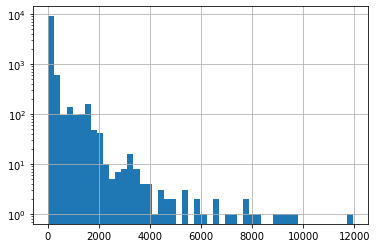

In [115]:
text_.loc[duplicates].sort_values('nb_tokens')['nb_tokens'].hist(bins=50, log=True)